In [1]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import re
import seaborn as sns
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import geopandas as gpd
import shapely.geometry

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain
from trajectory_post_funcs import calculate_heatmaps_from_trajectories
import customcmaps as ccmap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:3857") # have to manually set the projection
## set a column to be the first two numbers 
## get first two numbers of HUC8
basin_number = polys['HUC8'].values
newlist = [x[:2] for x in basin_number]
polys['basin'] = newlist
tmp = polys.dissolve(by='basin', aggfunc='sum')
tmp['basin'] = [10, 11, 13, 14]
tmp

,geometry,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC8,Name,Shape_Leng,Shape_Area,basin
basin,,,,,,,,,,,,,,,,,
10,"POLYGON ((-105.86763 39.49419, -105.86738 39.4...",1459,{88F45F9F-080F-45EF-9653-CC111BD4D053}{E180B15...,0,0,0,0,2012-06-112012-06-112012-06-112012-06-112012-0...,0,"29,440,289.37","119,140.77","COCOCOCO,KS,NECO,NECO,NECOCO,NE,WYCO,NECO,WYCO...",1019001110190013101900141025000110250005101900...,BijouBeaverPawneeArikareeFrenchmanLower South ...,146.54,12.61,10
11,"POLYGON ((-103.03204 36.72690, -103.03261 36.7...",984,{FD7D8C74-67B1-4679-A903-413DB9337C81}{2BD36A3...,0,0,0,0,2016-10-112012-06-112012-06-112012-06-112012-0...,0,"23,931,227.67","96,846.34","COCOCO,NMCOCOCO,KS,NM,OKCOCO,NM,OKCOCO,NMCO,KS...",1102000211020006110800011102000811020012110400...,Upper ArkansasHuerfanoCanadian HeadwatersHorse...,102.94,9.93,11
13,"POLYGON ((-105.23421 37.03533, -105.23449 37.0...",343,{3C828B69-1041-4E06-98D9-546F1A0AB778}{72C226B...,0,0,0,0,2012-06-112012-06-112017-09-202012-06-112017-0...,0,"8,975,607.30","36,323.02","CO,NMCO,NMCO,NMCOCO,NMCOCO",1301000513020102130100021301000413020101130100...,ConejosRio ChamaAlamosa-TrincheraSaguacheUpper...,33.43,3.68,13
14,"POLYGON ((-108.25677 36.48243, -108.25707 36.4...",1492,{75740F8C-AFFA-40B5-908E-4911BCB38D0B}{9CE10C9...,0,0,0,0,2012-06-112012-06-112012-06-112012-06-112012-0...,0,"35,639,918.22","144,229.79","CO,NMAZ,CO,NMCOCOCOCO,WYCO,UTCOCO,UTCO,UTCO,WY...",1408010714080105140200051402000214050002140401...,MancosMiddle San JuanLower GunnisonUpper Gunni...,144.55,15.01,14


In [4]:
start_mon = 1
end_mon = 12

## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
## get just Nov - April
PRISM = select_months_ds(PRISM, start_mon, end_mon, 'date')

HUC8_lst = PRISM.HUC8.values ## get list of HUC8 IDs

## a quick function that assigns each watershed a basin value 
## based on the first 2 numbers of the HUC8 identifier

basin_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    HUC2 = HUC8_ID[:2]
    if HUC2 == '14':
        basin = 'Upper Colorado'
    elif HUC2 == '13':
        basin = 'Rio Grande'
    elif HUC2 == '11':
        basin = 'Arkansas'
    elif HUC2 == '10':
        basin = 'Missouri'
   
    basin_lst.append(basin)
    
ds_lst = []
for i, HUC8_ID in enumerate(HUC8_lst):
    fname = path_to_data +'preprocessed/ERA5_trajectories/combined_extreme_AR/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    ds = xr.open_dataset(fname)
    ds_lst.append(ds)
    
## concat ds_lst along HUC8 index
ds = xr.concat(ds_lst, pd.Index(HUC8_lst, name="HUC8"))
## add the basin name as a coord
ds = ds.assign_coords({'basin': ("HUC8", basin_lst)})
ds

<xarray.Dataset>
Dimensions:             (index: 72, start_date: 1641, HUC8: 92)
Coordinates:
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
  * start_date          (start_date) datetime64[ns] 2000-01-11 ... 2023-12-26
    time                (HUC8, start_date, index) datetime64[ns] NaT NaT ... NaT
    lon                 (HUC8, start_date, index) float64 nan nan ... nan nan
    lat                 (HUC8, start_date, index) float64 nan nan ... nan nan
  * HUC8                (HUC8) object '14080107' '14080105' ... '10250013'
    basin               (HUC8) <U14 'Upper Colorado' ... 'Missouri'
Data variables: (12/20)
    level               (HUC8, start_date, index) float64 nan nan ... nan nan
    q                   (HUC8, start_date, index) float64 nan nan ... nan nan
    u                   (HUC8, start_date, index) float64 nan nan ... nan nan
    v                   (HUC8, start_date, index) float64 nan nan ... nan nan
    w                   (HUC8, start_date, index) float64 nan nan ... nan nan
    IVT                 (HUC8, start_date, index) float64 nan nan ... nan nan
    ...                  ...
    ar_strict           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    tARget_strict       (HUC8, start_date) float64 nan nan nan ... nan nan nan
    coastal_IVT_strict  (HUC8, start_date) float64 nan nan nan ... nan nan nan
    time_match          (HUC8, start_date) object nan nan nan ... nan nan nan
    lat_match           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    lon_match           (HUC8, start_date) float64 nan nan nan ... nan nan nan

In [5]:
ds_NDJFMA = select_months_ds(ds, 11, 4, 'start_date')
ds_MJJASO = select_months_ds(ds, 5, 10, 'start_date')

ds_lst = [ds_NDJFMA, ds_MJJASO]

ds_DJF = select_months_ds(ds, 12, 2, 'start_date')
ds_MAM = select_months_ds(ds, 3, 5, 'start_date')
ds_JJA = select_months_ds(ds, 6, 8, 'start_date')
ds_SON = select_months_ds(ds, 9, 11, 'start_date')

ds_lst2 = [ds_DJF, ds_MAM, ds_JJA, ds_SON]

In [6]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

ext = [-140., -90., 20, 50]

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

In [ ]:
titlestring = [['(a)', '(b)', '(c)', '(d)'],
               ['(e)', '(f)', '(g)', '(h)']]

nrows = 6
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 0.05, 0.05], width_ratios = [1, 1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(7.75, 10.))
fname = path_to_figs + 'heatmaps_basin_WY'
fmt = 'png'

############################
### PLOT AR SCALE VALUES ###
############################
plt_lbl = ['NDJFMA', 'MJJASO']
ssn_lst = ['NDJFMA', 'MJJASO']
basin_lst = ['Upper Colorado', 'Rio Grande', 'Missouri', 'Arkansas']
basin_id = [14, 13, 10, 11]

## Add color bar axis
cbax = plt.subplot(gs[-1,:]) # colorbar axis

for i, ssn in enumerate(ssn_lst):
    for j, basin_name in enumerate(basin_lst):
        if i == 0:
            llats = True
        elif i == 1:
            llats = False
        if j == 3:
            blons = True
        else: 
            blons = False
        print(ssn, basin_name)
        ax = fig.add_subplot(gs[j, i], projection=mapcrs)
        ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llats, right_lats=False, bottom_lons=blons)
        ax.set_extent(ext, datacrs)
        ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
        
        if j == 0: # add column label to top row only
            ax.set_title(ssn, loc='left', fontsize=14)
        
        if i == 0: # add row labels to the far left plot
            ax.text(-0.16, 0.5, basin_name, va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
    
        ds = ds_lst[i].where(ds_lst[i].basin==basin_name, drop=True)
        AR = ds.where(ds.ar_scale > 0, drop=True)
        ## now calculate heatmaps from remaining trajectories
        cell = calculate_heatmaps_from_trajectories(AR, normalize=False)

        ## create segmented cmap
        # cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 1.1, .1))
        cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 110, 10))
        ## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
        cf = cell.plot(ax=ax, column='n_traj', cmap=cmap, vmin=bnds[0], vmax=bnds[-1], norm=norm, edgecolor=None, legend=True, cax=cbax,
                      legend_kwds={"label": "Trajectory Frequency (count)", "orientation": "horizontal"})


        ## add in four basins
        plot_poly = tmp[(tmp.basin == basin_id[j])]
        plot_poly.crs = 'epsg:3857'
        print(plot_poly.crs)
        plot_poly.plot(ax=ax, edgecolor='black', color='None', zorder=99)

        ax.text(0.03, 0.96, titlestring[i][j], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)



fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

In [ ]:
nrows = 4
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.05, 0.05], width_ratios = [1, 1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(8.0, 5.5))
fig.dpi = 600
fname = path_to_figs + 'heatmaps_basin_WY_subset'
fmt = 'png'

############################
### PLOT AR SCALE VALUES ###
############################
plt_lbl = ['NDJFMA', 'MJJASO']
colors = ['#0ac1ff', '#04ff03', '#ffff03', '#ffa602', '#ff0100']
left_lats = [True, False]
bottom_lons = [False, True]
ssn_lst = ['NDJFMA', 'MJJASO']
basin_lst = ['Upper Colorado', 'Missouri']
basin_id = [14, 10]

## Add color bar axis
cbax = plt.subplot(gs[-1,:]) # colorbar axis

for i, ssn in enumerate(ssn_lst):
    for j, basin_name in enumerate(basin_lst):
        print(ssn, basin_name)
        ax = fig.add_subplot(gs[i, j], projection=mapcrs)
        ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=left_lats[j], right_lats=False, bottom_lons=bottom_lons[i])
        ax.set_extent(ext, datacrs)
        ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
        
        if i == 0: # add column label to top row only
            ax.set_title(basin_name, loc='left', fontsize=14)
        
        if j == 0: # add row labels to the far left plot
            ax.text(-0.16, 0.5, ssn_lst[i], va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
    
        ds = ds_lst[i].where(ds_lst[i].basin==basin_name, drop=True)
        AR = ds.where(ds.ar_scale > 0, drop=True)
        ## now calculate heatmaps from remaining trajectories
        cell = calculate_heatmaps_from_trajectories(AR, normalize=False)

        ## create segmented cmap
        # cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 1.1, .1))
        cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 110, 10))
        ## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
        cf = cell.plot(ax=ax, column='n_traj', cmap=cmap, vmin=bnds[0], vmax=bnds[-1], norm=norm, edgecolor=None, legend=True, cax=cbax,
                      legend_kwds={"label": "Trajectory Frequency (count)", "orientation": "horizontal"})


        ## add in four basins
        plot_poly = tmp[(tmp.basin == basin_id[j])]
        plot_poly.crs = 'epsg:3857'
        print(plot_poly.crs)
        plot_poly.plot(ax=ax, edgecolor='black', color='None', zorder=99)


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

In [ ]:
nrows = 6
ncols = 4

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 0.05, 0.05], width_ratios = [1, 1, 1, 1], wspace=0.01, hspace=0.05)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(15.0, 10.0))
fig.dpi = 600
fname = path_to_figs + 'heatmaps_basin_SSN'
fmt = 'png'

############################
### PLOT AR SCALE VALUES ###
############################
plt_lbl = ['DJF', 'MAM', 'JJA', 'SON']
colors = ['#0ac1ff', '#04ff03', '#ffff03', '#ffa602', '#ff0100']
left_lats = [True, False, False, False]
bottom_lons = [False, False, False, True]
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON']
basin_lst = ['Upper Colorado', 'Rio Grande', 'Missouri', 'Arkansas']
basin_id = [14, 13, 10, 11]
titlestring = [['(a)', '(b)', '(c)', '(d)'],
               ['(e)', '(f)', '(g)', '(h)'],
               ['(i)', '(j)', '(k)', '(l)'],
               ['(m)', '(n)', '(o)', '(p)']]
## Add color bar
cbax = plt.subplot(gs[-1,:]) # colorbar axis

for i, ssn in enumerate(ssn_lst):
    for j, basin_name in enumerate(basin_lst):
        print(ssn, basin_name)
        ax = fig.add_subplot(gs[i, j], projection=mapcrs)
        ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=left_lats[j], right_lats=False, bottom_lons=bottom_lons[i])
        ax.set_extent(ext, datacrs)
        ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
        
        if i == 0: # add column label to top row only
            ax.set_title(basin_name, loc='left', fontsize=14)
        
        if j == 0: # add row labels to the far left plot
            ax.text(-0.16, 0.5, ssn_lst[i], va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
    
        ds = ds_lst2[i].where(ds_lst2[i].basin==basin_name, drop=True)
        AR = ds.where(ds.ar_scale > 0, drop=True)
        ## now calculate heatmaps from remaining trajectories
        cell = calculate_heatmaps_from_trajectories(AR, normalize=False)
        # cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 1.1, .1))
        cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 110, 10))
        ## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
        cf = cell.plot(ax=ax, column='n_traj', cmap=cmap, vmin=bnds[0], vmax=bnds[-1], norm=norm, edgecolor=None, legend=True, cax=cbax,
                      legend_kwds={"label": "Trajectory Frequency (count)", "orientation": "horizontal"})


        ## add in four basins
        plot_poly = tmp[(tmp.basin == basin_id[j])]
        plot_poly.crs = 'epsg:3857'
        print(plot_poly.crs)
        plot_poly.plot(ax=ax, edgecolor='black', color='None', zorder=99)
        ax.text(0.03, 0.96, titlestring[i][j], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)



fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

In [ ]:
titlestring = [['(a)', '(b)', '(c)', '(d)'],
               ['(e)', '(f)', '(g)', '(h)']]

nrows = 6
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1, 0.05, 0.05], width_ratios = [1, 1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(7.75, 10.))
fname = path_to_figs + 'heatmaps_basin_WY_nonAR'
fmt = 'png'

############################
### PLOT AR SCALE VALUES ###
############################
plt_lbl = ['NDJFMA', 'MJJASO']
ssn_lst = ['NDJFMA', 'MJJASO']
basin_lst = ['Upper Colorado', 'Rio Grande', 'Missouri', 'Arkansas']
basin_id = [14, 13, 10, 11]

## Add color bar axis
cbax = plt.subplot(gs[-1,:]) # colorbar axis

for i, ssn in enumerate(ssn_lst):
    for j, basin_name in enumerate(basin_lst):
        if i == 0:
            llats = True
        elif i == 1:
            llats = False
        if j == 3:
            blons = True
        else: 
            blons = False
        print(ssn, basin_name)
        ax = fig.add_subplot(gs[j, i], projection=mapcrs)
        ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llats, right_lats=False, bottom_lons=blons)
        ax.set_extent(ext, datacrs)
        ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
        
        if j == 0: # add column label to top row only
            ax.set_title(ssn, loc='left', fontsize=14)
        
        if i == 0: # add row labels to the far left plot
            ax.text(-0.16, 0.5, basin_name, va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)
    
        ds = ds_lst[i].where(ds_lst[i].basin==basin_name, drop=True)
        AR = ds.where(ds.ar_scale.isnull(), drop=True)
        ## now calculate heatmaps from remaining trajectories
        cell = calculate_heatmaps_from_trajectories(AR, normalize=False, AR=False)

        ## create segmented cmap
        # cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 1.1, .1))
        cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 425, 25))
        ## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
        cf = cell.plot(ax=ax, column='n_traj', cmap=cmap, vmin=bnds[0], vmax=bnds[-1], norm=norm, edgecolor=None, legend=True, cax=cbax,
                      legend_kwds={"label": "Trajectory Frequency (count)", "orientation": "horizontal"})


        ## add in four basins
        plot_poly = tmp[(tmp.basin == basin_id[j])]
        plot_poly.crs = 'epsg:3857'
        print(plot_poly.crs)
        plot_poly.plot(ax=ax, edgecolor='black', color='None', zorder=99)

        ax.text(0.03, 0.96, titlestring[i][j], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)



fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

NDJFMA
epsg:3857
MJJASO
epsg:3857


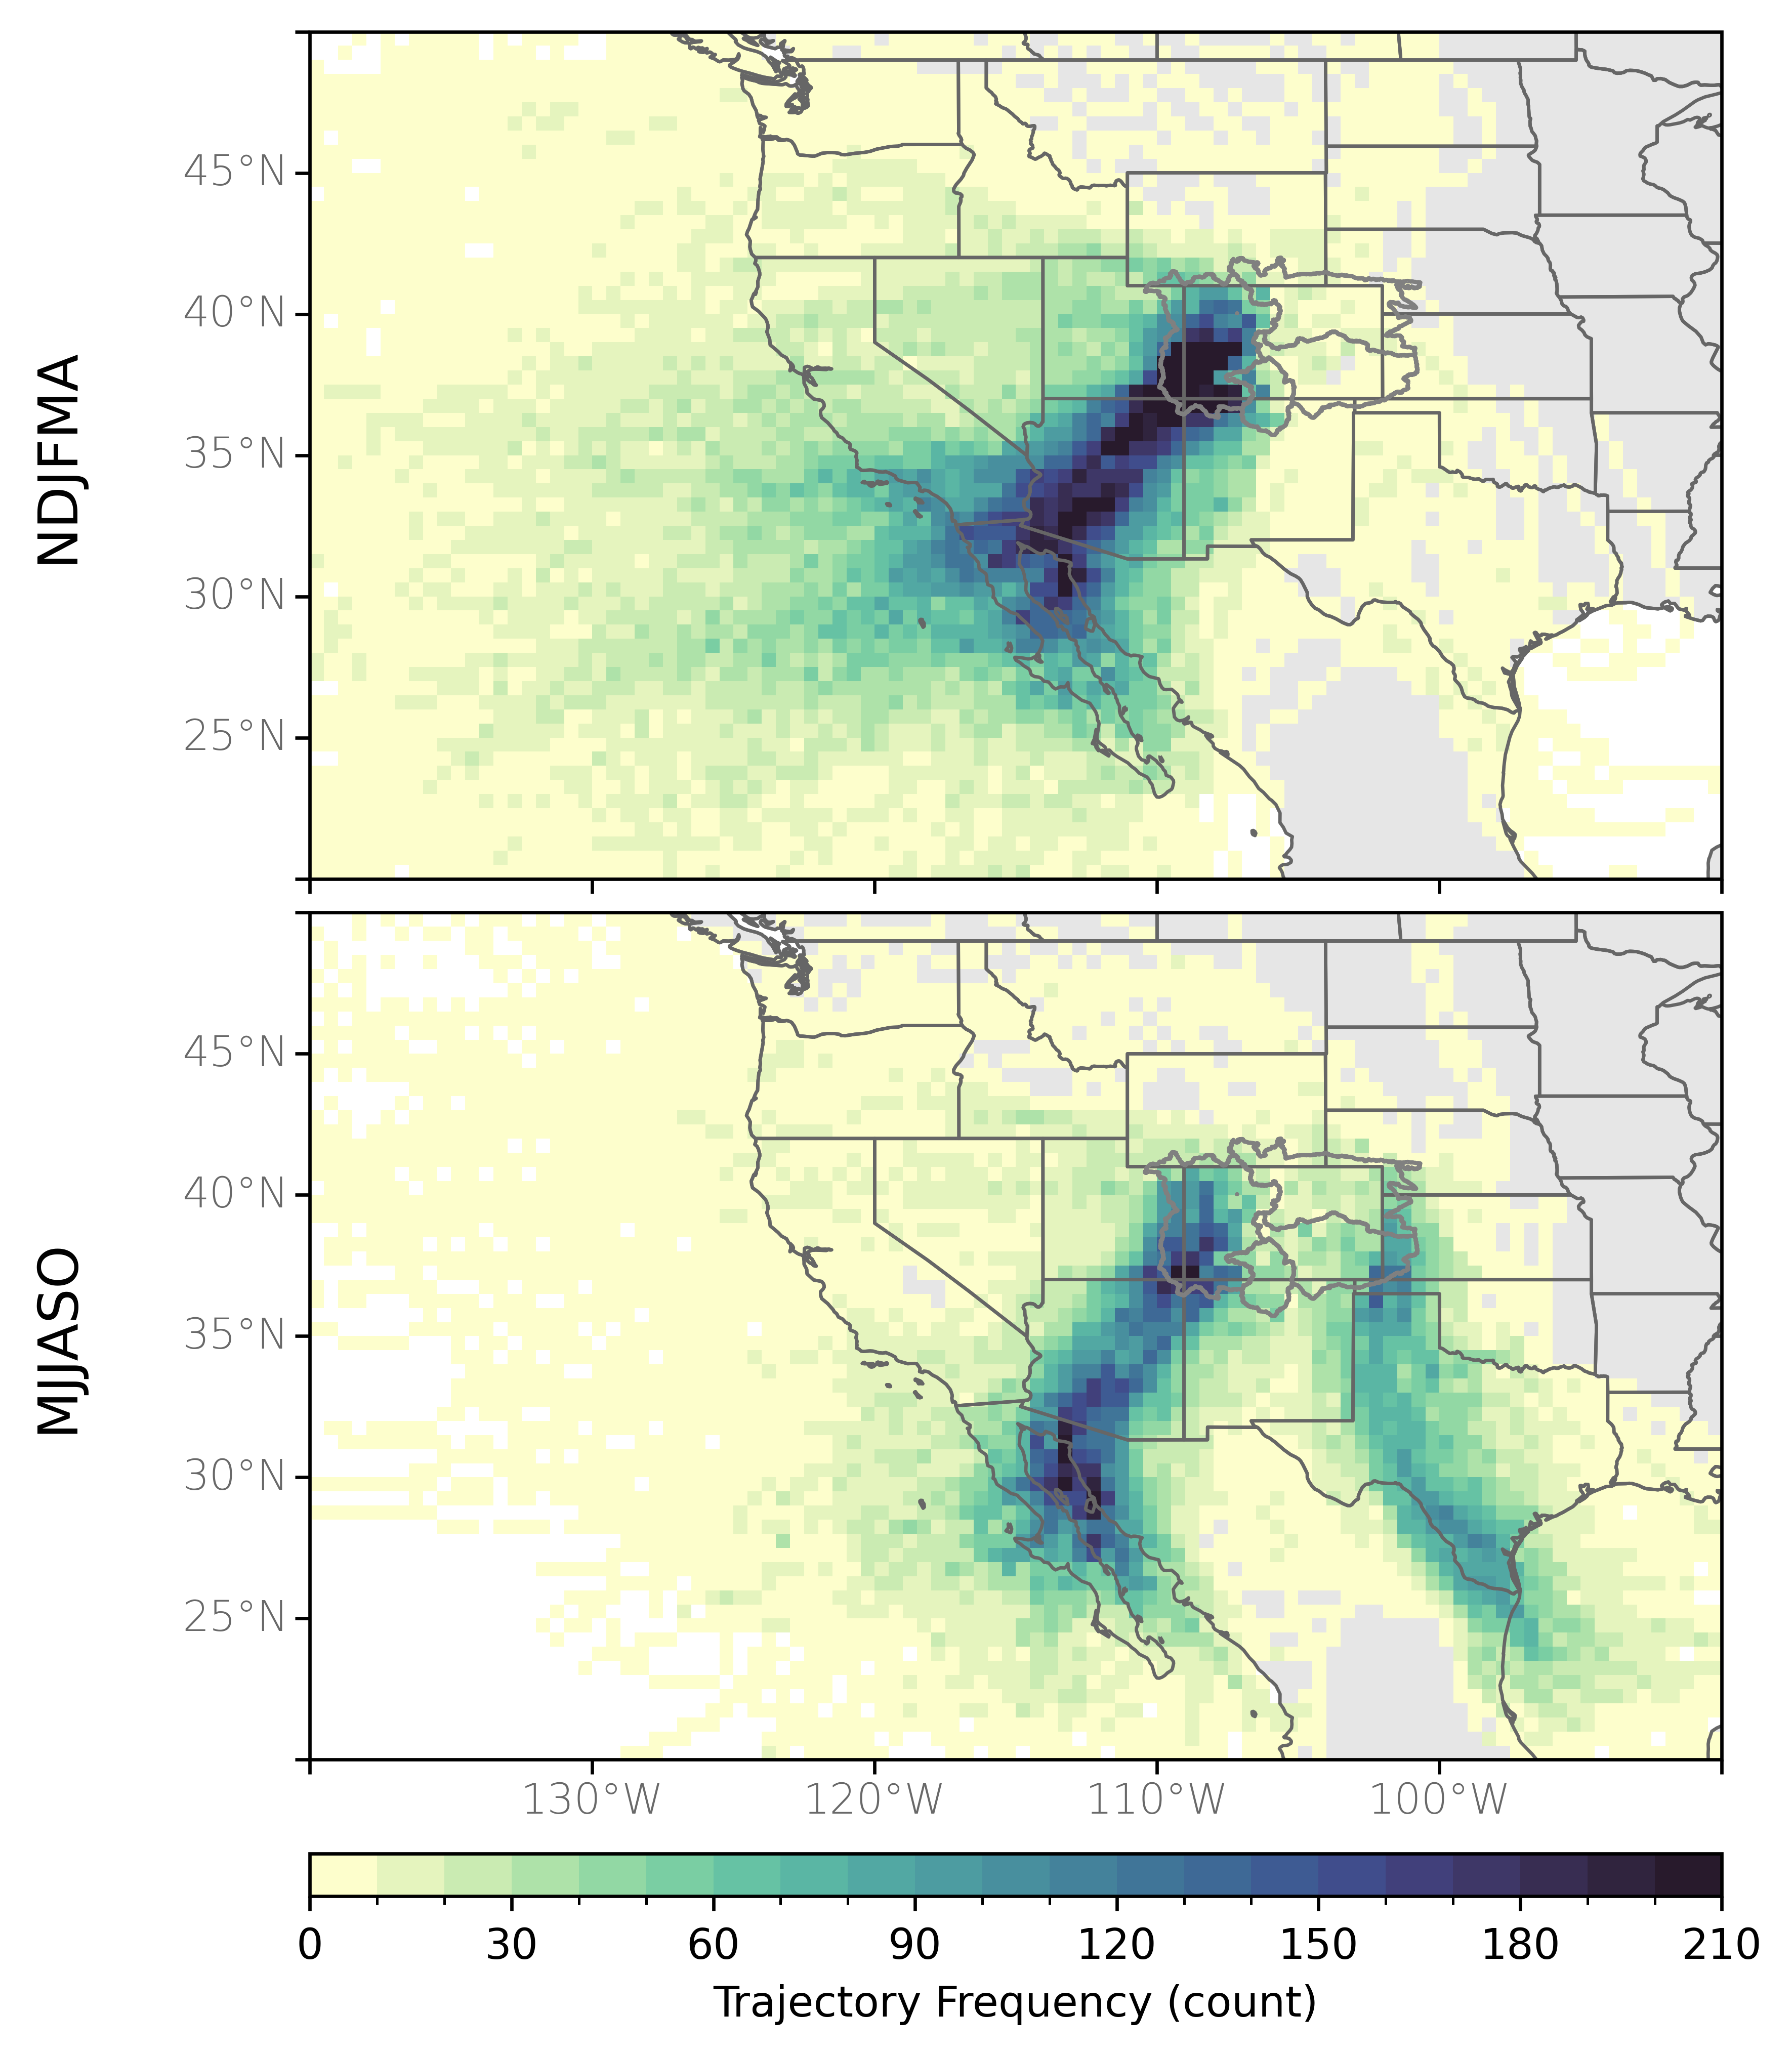

In [13]:
nrows = 4
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.05, 0.05], width_ratios = [1], wspace=0.01, hspace=0.05)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(6., 8.))
fig.dpi = 600
fname = path_to_figs + 'heatmaps_all_WY'
fmt = 'png'

############################
### PLOT AR SCALE VALUES ###
############################
plt_lbl = ['NDJFMA', 'MJJASO']
bottom_lons = [False, True]
ssn_lst = ['NDJFMA', 'MJJASO']
cbax = plt.subplot(gs[-1,:]) # colorbar axis


for i, ssn in enumerate(ssn_lst):
    print(ssn)
    ax = fig.add_subplot(gs[i, 0], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=bottom_lons[i])
    ax.set_extent(ext, datacrs)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

    # add row labels to the far left plot
    ax.text(-0.16, 0.5, ssn_lst[i], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=ax.transAxes)

    ds = ds_lst[i]
    AR = ds.where(ds.ar_scale > 0, drop=True)
    ## now calculate heatmaps from remaining trajectories
    cell = calculate_heatmaps_from_trajectories(AR, normalize=False)

    ## create segmented cmap
    # cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 1.1, .1))
    cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 220, 10))
    ## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
    cf = cell.plot(ax=ax, column='n_traj', cmap=cmap, vmin=bnds[0], vmax=bnds[-1], norm=norm, edgecolor=None, legend=True, cax=cbax,
                  legend_kwds={"label": "Trajectory Frequency (count)", "orientation": "horizontal"})


    ## add in four basins
    plot_poly = tmp
    plot_poly.crs = 'epsg:3857'
    print(plot_poly.crs)
    plot_poly.plot(ax=ax, edgecolor='gray', color='None', zorder=99)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()